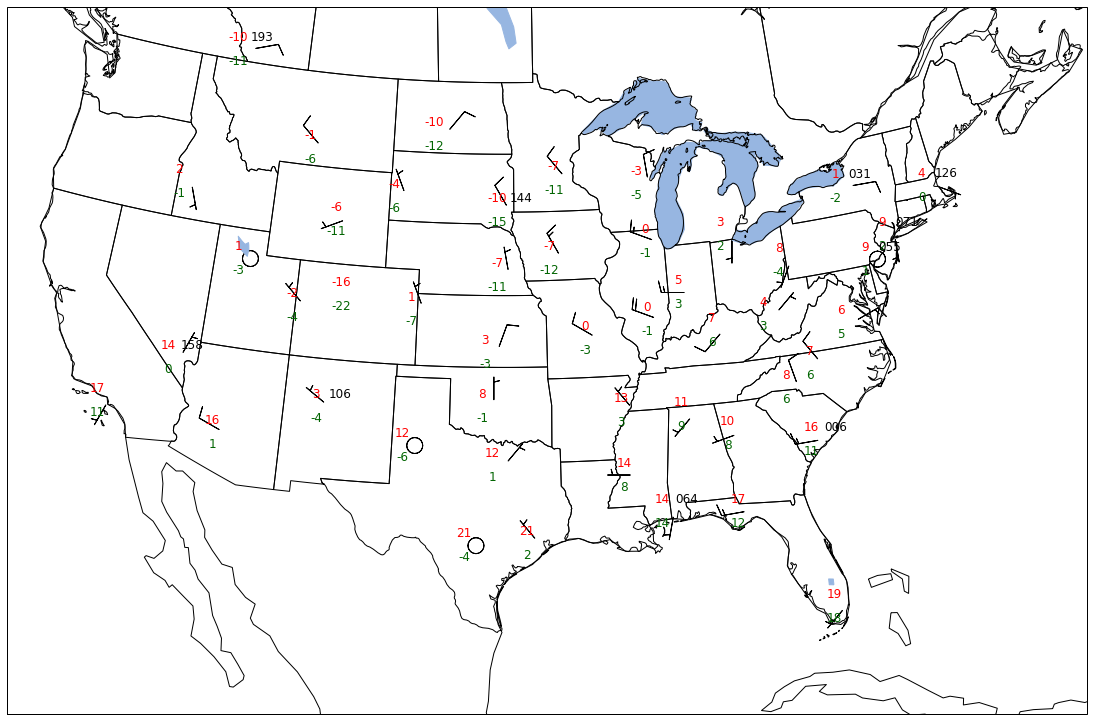

In [43]:
from traitlets.config.configurable import Configurable
from traitlets import HasTraits, Int, Float, Unicode, Bool, Any, Dict, List
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.calc import get_wind_components
from metpy.units import units


class MetpyMap(HasTraits):

    file_location = Unicode(allow_none=False, help='location of the data file').tag(config=True)

    bbox = Dict(traits={"east": Float(allow_none=False), "west": Float(allow_none=False),
                        "north": Float(allow_none=False), "south": Float(allow_none=False)},
                help='map bounding box').tag(config=True) 
    
    avail_features = {
                      'BORDERS': cartopy.feature.BORDERS, 
                      'COASTLINE': cartopy.feature.COASTLINE, 
                      'LAKES': cartopy.feature.LAKES, 
                      'LAND': cartopy.feature.LAND,
                      'OCEAN': cartopy.feature.OCEAN, 
                      'RIVERS': cartopy.feature.RIVERS,
                      'STATES': cartopy.feature.NaturalEarthFeature(
                                    category='cultural',
                                    name='admin_1_states_provinces_lakes',
                                    scale='50m',
                                    facecolor='none')
                     }
    
    features = Dict(default_value={f : False for f in avail_features.keys()}, 
                    traits={f : Bool() for f in avail_features.keys()},
                    help='Toggle features to draw').tag(config=True)

    projection_options = Dict(traits={"from_proj": Any(allow_none=False), 
                                      "to_proj": Any(allow_none=False)},
                              help='projection options').tag(config=True)
    
    def draw_map(self, view):

        view.set_extent([self.bbox['west'], self.bbox['east'], 
                         self.bbox['south'], self.bbox['north']])

        for key, activated in self.features.items():
            if activated and key in self.avail_features:
                print(self.avail_features[key])
                view.add_feature(self.avail_features[key])
            
        return view


class StationMap(MetpyMap):
    
    def __init__(self, file, bbox, **kwargs):
        
        self.file_location = file
        
        self.bbox = bbox
        
        usr_features = kwargs['features'].keys()
        for feature in self.features.keys():
            if feature in usr_features:
                self.features[feature] = kwargs['features'][feature] 
        
        self.projection_options = kwargs['proj_options']
        
        self.data = self.load_text()
        
                
    def load_text(self):

        f = get_test_data(self.file_location)

        all_data = np.loadtxt(f, skiprows=1, delimiter=',',
                              usecols=(1, 2, 3, 4, 5, 6, 7, 17, 18, 19),
                              dtype=np.dtype([('stid', '3S'), ('lat', 'f'), ('lon', 'f'),
                                              ('slp', 'f'), ('air_temperature', 'f'),
                                              ('cloud_fraction', 'f'), ('dewpoint', 'f'),
                                              ('weather', '16S'),
                                              ('wind_dir', 'f'), ('wind_speed', 'f')]))

        all_stids = [s.decode('ascii') for s in all_data['stid']]

        whitelist = ['OKC', 'ICT', 'GLD', 'MEM', 'BOS', 'MIA', 'MOB', 'ABQ', 'PHX', 'TTF',
                     'ORD', 'BIL', 'BIS', 'CPR', 'LAX', 'ATL', 'MSP', 'SLC', 'DFW', 'NYC', 'PHL',
                     'PIT', 'IND', 'OLY', 'SYR', 'LEX', 'CHS', 'TLH', 'HOU', 'GJT', 'LBB', 'LSV',
                     'GRB', 'CLT', 'LNK', 'DSM', 'BOI', 'FSD', 'RAP', 'RIC', 'JAN', 'HSV', 'CRW',
                     'SAT', 'BUY', '0CO', 'ZPC', 'VIH']

        # Loop over all the whitelisted sites, grab the first data, and concatenate them
        return np.concatenate([all_data[all_stids.index(site)].reshape(1, ) for site in whitelist])
    
    
    def draw_map(self, view):

        from_proj = self.projection_options['from_proj']

        view = MetpyMap.draw_map(self, view)

        x = self.data['lon']
        y = self.data['lat']

        u, v = get_wind_components((self.data['wind_speed'] * units('m/s')).to('knots'),
                                    self.data['wind_dir'] * units.degree)

        stationplot = StationPlot(view, x, y, transform=from_proj,
                                  fontsize=12)

        stationplot.plot_parameter('NW', self.data['air_temperature'], color='red')
        stationplot.plot_parameter('SW', self.data['dewpoint'], color='darkgreen')

        stationplot.plot_parameter('NE', self.data['slp'],
                                   formatter=lambda sp: format(10 * sp, '.0f')[-3:])

        stationplot.plot_barb(u, v)

        return view

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

sp = StationMap("station_data.txt", 
                {"east": -70, "west": -120, "north": 50, "south": 20},
                features={"COASTLINE": True, "LAKES": True, "STATES": True},
                proj_options={"to_proj": to_proj, "from_proj": from_proj})

view = plt.axes([0, 0, 1, 1], projection=to_proj)

sp.draw_map(view)

In [44]:
sp = StationMap(25, 
                {"east": -70, "west": -120, "north": 50, "south": 20},
                features={"COASTLINE": True, "LAKES": True, "STATES": True},
                proj_options={"to_proj": to_proj, "from_proj": from_proj})

TraitError: The 'file_location' trait of a StationMap instance must be a unicode string, but a value of 25 <class 'int'> was specified.

In [45]:
sp = StationMap("station_data.txt", 
                {"east": "Negative Seventy", "west": -120, "north": 50, "south": 20},
                features={"COASTLINE": True, "LAKES": True, "STATES": True},
                proj_options={"to_proj": to_proj, "from_proj": from_proj})

AttributeError: 'NoneType' object has no attribute 'info'

In [46]:
sp = StationMap("station_data.txt", 
                {"east": -70, "west": -120, "north": 50, "south": 20},
                features={"COASTLINE": True, "LAKES": True, "STATES": True},
                proj_options={"to_proj": "a", "from_proj": from_proj})